In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

In [2]:
# Loading dataset

# words_df = pd.read_csv('data/Indian-Male-Names.csv')
words_df = pd.read_csv('data/Indian-Female-Names.csv')
words_list = words_df.values.tolist()

# First 10 names
import re
patt = r'^[A-Za-z\s]+$'
words = [w[0].split()[0] for w in words_list if type(w[0]) == str and bool(re.match(patt, w[0]))]
words[:10]

['shivani',
 'isha',
 'smt',
 'divya',
 'mansi',
 'mazida',
 'pooja',
 'kajal',
 'meena',
 'sonam']

In [3]:
# loading dataset
# words = open('names.txt', 'r').read().splitlines()
# words[:10]

In [4]:
len(words)

13992

In [5]:
# Creating the lookup dictionaries for the string to integer and integer to string
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
itos

{1: 'a',
 2: 'b',
 3: 'c',
 4: 'd',
 5: 'e',
 6: 'f',
 7: 'g',
 8: 'h',
 9: 'i',
 10: 'j',
 11: 'k',
 12: 'l',
 13: 'm',
 14: 'n',
 15: 'o',
 16: 'p',
 17: 'q',
 18: 'r',
 19: 's',
 20: 't',
 21: 'u',
 22: 'v',
 23: 'w',
 24: 'x',
 25: 'y',
 26: 'z',
 0: '.'}

## Using MLP

In [6]:
# Function to create a dataset taking input as data and the lookbehind_size(how much characters to look back while predicting next)
def make_dataset(words, lookbehind_size=6):
    X, Y = [], []
    for w in words:
        context = [0]*lookbehind_size
        for char in w+'.':
            i = stoi[char]
            X.append(context)
            Y.append(i)
            context = context[1:] + [i]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X,Y

In [7]:
#Splitting Dataset randomly
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))
lookbehind_size = 4
x_train, y_train = make_dataset(words[:n1], lookbehind_size)
x_val, y_val = make_dataset(words[n1:n2], lookbehind_size)
x_test, y_test = make_dataset(words[n2:], lookbehind_size)

In [8]:
x_train.shape, y_train.shape

(torch.Size([73432, 4]), torch.Size([73432]))

In [9]:
# Creating weights and biases for the model
g = torch.Generator().manual_seed(2147483647)
# C is the lookup table for the chracters which maps each character into n dimensional vector
n = 10
C = torch.randn((27,n), generator=g, requires_grad=True)
# lookbehind_size no of characters are stacked one upon another, each n dimensional creating a total of
# n*lookbehind_size units

# creating weights and biases
w1 = torch.randn((n*lookbehind_size,300), generator=g, requires_grad=True)
b1 = torch.randn(300, generator=g, requires_grad=True)
w2 = torch.randn((300, 27), generator=g, requires_grad=True)
b2 = torch.randn(27, generator=g, requires_grad=True)
parameters = [C, w1, b1, w2, b2]

In [10]:
sum(p.nelement() for p in parameters) #Total parameters

20697

## Checking for a good learning rate

In [11]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [12]:
lres, losses = [], []
for i in range(1000):
    
    # Mini batches of size 64
    ix = torch.randint(0, x_train.shape[0], (64,))
    
    # forward pass
    emb = C[x_train[ix]]
    
    # stacking the n dimensional vectors on top of others
    h = torch.tanh(emb.view(-1, n*lookbehind_size)@w1+b1)
    
    # getting logits
    logits = h@w2+b2
    # Calculating cross entropy loss
    loss = F.cross_entropy(logits, y_train[ix])
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = lrs[i]
    lres.append(lr)
    losses.append(loss.item())
#     if i<40000:
#         lr = 0.1
#     else:
#         lr = 0.01
    for p in parameters:
        p.data += -lr*p.grad
print(loss)

tensor(13.4984, grad_fn=<NllLossBackward0>)


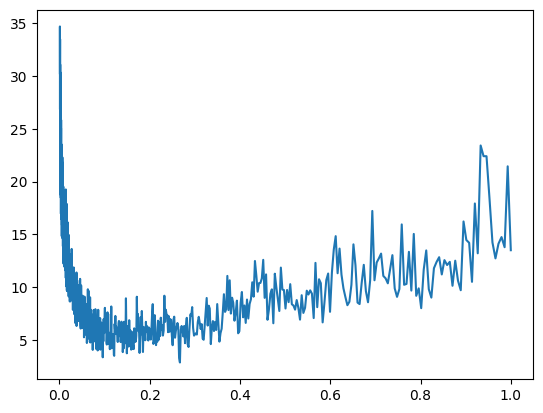

In [13]:
plt.plot(lres, losses)

## Training on the good learning rate

In [14]:
iters, losses = [], []
for i in range(50000):
    
    # Mini batches of size 64
    ix = torch.randint(0, x_train.shape[0], (64,))
    
    # forward pass
    emb = C[x_train[ix]]
    
    # stacking the n dimensional vectors on top of others
    h = torch.tanh(emb.view(-1, n*lookbehind_size)@w1+b1)
    
    # getting logits
    logits = h@w2+b2
    # Calculating cross entropy loss
    loss = F.cross_entropy(logits, y_train[ix])
    iters.append(i)
    losses.append(loss.item())
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    # update
    lr = 0.0
    if i<40000:
        lr = 0.1
    else:
        lr = 0.01
    for p in parameters:
        p.data += -lr*p.grad
print(loss)

tensor(1.0701, grad_fn=<NllLossBackward0>)


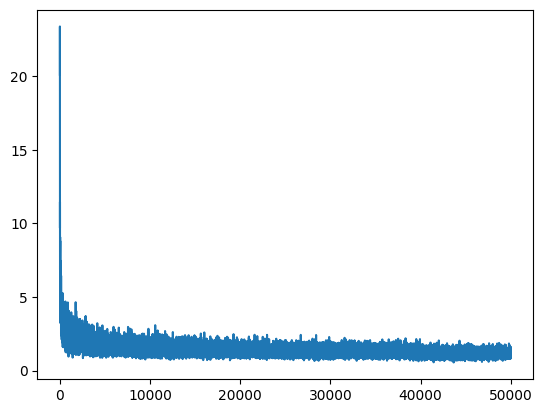

In [15]:
plt.plot(iters, losses)

In [16]:
# Testing error
emb = C[x_test]
h = torch.tanh(emb.view(-1, n*lookbehind_size)@w1+b1)
logits = h@w2+b2
loss = F.cross_entropy(logits, y_test)
print(loss)

tensor(1.4711, grad_fn=<NllLossBackward0>)


## Generating random new names

In [17]:
g = torch.Generator().manual_seed(2147483647+10)

In [18]:
# Randomly creating names with this model
# print(len(words))
for _ in range(20):
    out = []
    context = [0]*lookbehind_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1)@w1+b1)
        logits = h@w2+b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:]+[ix]
        out.append(ix)
        if ix == 0:
            break
    name = ''.join(itos[i] for i in out)
#     print("1", name)
    if name[:-1] not in words:
        print(name[:-1])

heen
sheelam
areeeni
katumashu
